<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Topic Trend Dashboard using ONNXEmbeddings and VectorDistance
 <br>       
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 150px; height: auto; margin-top: 20pt;">
  <br>
    </p>
</header>

![](images/topictrenddashboard.gif)

> **When to Use This Recipe**
> - ✅ You have a history of complaints, text messages, etc., that may contain varying topics.
> - ✅ You want to understand the trends of those topics over time.
> - ✅ You have a list of predefined topics as well as ad-hoc topics.
> - ✅ You need replicable results without variability introduced by LLM-based evaluations.  

# Introduction

Tracking the evolution of topics over time is essential for understanding patterns, behaviors, and emerging trends in large datasets of text. In industries such as customer support, social media monitoring, and market research, identifying how topics shift over time can provide valuable insights for decision-making and strategy development. Traditional manual analysis methods, however, can be labor-intensive and prone to human bias.

In this blog post, we explore a dynamic approach to topic trend analysis by combining message embeddings with topic embeddings, leveraging vector distance calculations to measure similarity between the two. The resulting data will be fed into an interactive dashboard, enabling users to monitor the frequency of topics over specific time periods and set similarity thresholds for enhanced relevance.

While the specific example can be applied across many sectors, we’ll focus on a use case using the Consumer Complaint Database from the Consumer Financial Protection Bureau. This dataset contains complaints about financial products and services, providing valuable insights into consumer sentiment and trends. By categorizing these complaints by topic, businesses can gain a deeper understanding of customer concerns in the consumer finance sector and adjust their strategies to address emerging issues more effectively.

To achieve this, we will:

- Generate embeddings for both customer messages and inferred/predefined topics
- Calculate vector distances between message and topic embeddings to assess similarity
- Feed the results into a dashboard to display topic trends over time, with configurable similarity thresholds and message counts
- Enable entries of new topics in the dashboard, allowing ad-hoc analyses.

The approach is visually represented in this diagram:

![workflow chart](images/workflow_topictrend.png)

This method provides an efficient way to not only categorize messages by topic but also track how these topics evolve over time, offering actionable insights into changing customer concerns, emerging issues, and overall trends.

# Dataset Overview

For this analysis, we use the **Consumer Complaint Database**, a publicly available dataset from the **Consumer Financial Protection Bureau (CFPB)** in the United States. This dataset contains consumer complaints related to financial products and services, helping to identify trends and issues affecting consumers. The CFPB collects and publishes these complaints to promote transparency and consumer protection in the financial industry. The dataset has been used by researchers, regulators, and businesses to analyze market trends, detect fraud, and improve customer service.

The full dataset, starting from **2011**, contains over **8 million complaints**. For this blog post, we apply filters to focus on a manageable subset for analysis. We apply the following filters and obtain around **80k complaints**:

- **Time Range:** Full year **2024**  
- **Consent:** Complaints where consumers have provided consent to publish their narratives  
- **Geographic Scope:** Complaints from the state of **California**  

The filtered dataset can be accessed here:  
[Download Filtered Dataset (CSV)](https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?consumer_consent_provided=Consent%20provided&date_received_max=2024-12-31&date_received_min=2024-01-01&field=all&format=csv&no_aggs=true&size=80767&state=CA)  

For more details on the dataset fields, refer to the official [CFPB API documentation](https://cfpb.github.io/api/ccdb/fields.html).
The dataset consists of multiple fields that describe each complaint, including product type, issue, company response, and consumer-provided narratives. Below is an overview of key fields:

| **Field Name**                 | **Description**                                                             |
|--------------------------------|-----------------------------------------------------------------------------|
| `complaint_id`                 | Unique identifier for each complaint.                                       |
| `date_received`                | Date the complaint was received by the CFPB.                               |
| `product`                      | The type of financial product (e.g., mortgage, credit card).               |
| `sub_product`                  | More specific product type (e.g., FHA mortgage, private student loan).     |
| `issue`                        | The issue the consumer is complaining about (e.g., loan modification).     |
| `sub_issue`                    | More detailed issue category.                                              |
| `consumer_complaint_narrative`  | The consumer's description of the complaint.                              |
| `company_public_response`       | The company's public response to the complaint.                            |
| `company`                      | The financial institution involved.                                        |
| `state`                        | The state where the consumer is located.                                   |
| `zip_code`                     | The consumer's ZIP code.                                                   |
| `tags`                         | Tags indicating special characteristics of the complaint (e.g., servicemember). |
| `consumer_consent_provided`     | Indicates if the consumer consented to publish their narrative.           |
| `submitted_via`                | How the complaint was submitted (e.g., web, phone).                       |
| `date_sent_to_company`         | Date the complaint was forwarded to the company.                          |
| `company_response`             | The company's response to the complaint.                                   |
| `timely_response`              | Indicates if the company responded in a timely manner.                    |
| `consumer_disputed`            | Indicates if the consumer disputed the company's response.                 |
| `complaint_what_happened`      | A detailed narrative of the consumer's experience.                        |

In the following sections, we will walk through the methodology for embedding generation, similarity analysis, and dashboard visualization.


# Demo Setup

We start by installing and importing the required Python packages.

In [1]:
%%capture
!pip install teradataml --upgrade
!pip install teradatasqlalchemy --upgrade

In [2]:
import teradataml as tdml
print(tdml.__version__)
tdml.display.enable_ui = False # just display the normal DataFrame, available from version 20.00.00.04

20.00.00.04


In [3]:
# imports a function `display_dataframes_in_tabs` and `display_wordclouds_in_tabs`
%run utils/tab_widget.py

In [4]:
list_relevant_tables = [] # we will be adding names of relevant tables progressivley into this list to display the tables

We’ll move on by connecting to our Vantage instance and loading the datasets into a table. Just a heads-up—this is for demo purposes only. In a real-world setup, your data would already be stored in a cloud data platform like Teradata Vantage.

In [6]:
import getpass
host = getpass.getpass("Enter your host name here, can be found on the ClearScape Experience Dashboard")
username = getpass.getpass("Enter you username here, on ClearScape Experience it will be demo_user")
password = getpass.getpass("Enter your password here")

Enter your host name here, can be found on the ClearScape Experience Dashboard ········
Enter you username here, on ClearScape Experience it will be demo_user ········
Enter your password here ········


In [7]:
eng = tdml.create_context(host = host, username=username, password = password)

In [8]:
%run utils/_dataload.ipynb 
#takes currently 15 minutes (as it's more than 600 MB of data)

consumer_complaints already exists
consumer_complaints has got the right shape
consumer_embeddings already exists
consumer_embeddings has got the right shape


In [9]:
list_relevant_tables.append("consumer_complaints")

In [ ]:
DF_complaints = tdml.DataFrame("consumer_complaints")

In [10]:
display_dataframes_in_tabs(list_relevant_tables)

In addition, we want to check if our database has already got the required functionality to generate embeddings.

In [11]:
VCL = False # current system is VCE/VCore

In [12]:
if VCL:
    results = tdml.execute_sql("help database mldb").fetchall()
else:
    results = tdml.execute_sql("help user mldb").fetchall()

embeddings_functions = [x[0] for x in results if x[0].startswith("ONNXEmbeddings")]
if len(embeddings_functions) >0:#
    print("\n".join(embeddings_functions))
    print("---------------------\nONNXEmbeddings is installed")
else:
    print("ONNXEmbeddings is not installed. Please Upgrade to BYOM version 6")

ONNXEmbeddings                                                                            
ONNXEmbeddings_contract                                                                   
---------------------
ONNXEmbeddings is installed


# Load HuggingFace Model

To generate embeddings, we need an ONNX model capable of transforming text into vector representations. We use a pretrained model from [Teradata's Hugging Face repository](https://huggingface.co/Teradata/gte-base-en-v1.5), such as gte-base-en-v1.5. The model and its tokenizer are downloaded and stored in Vantage tables as BLOBs using the save_byom function.

In [13]:
from huggingface_hub import hf_hub_download

model_name = "gte-base-en-v1.5"
number_dimensions_output = 768
model_file_name = "model.onnx" 

In [14]:
# Step 1: Download Model from Teradata HuggingFace Page

hf_hub_download(repo_id=f"Teradata/{model_name}", filename=f"onnx/{model_file_name}", local_dir="./")
hf_hub_download(repo_id=f"Teradata/{model_name}", filename=f"tokenizer.json", local_dir="./")

'tokenizer.json'

In [15]:
try:
    tdml.db_drop_table("embeddings_models")
except:
    pass
try:
    tdml.db_drop_table("embeddings_tokenizers")
except:
    pass

In [16]:
# Step 2: Load Models into Vantage
# a) Embedding model
tdml.save_byom(model_id = model_name, # must be unique in the models table
               model_file = f"onnx/{model_file_name}",
               table_name = 'embeddings_models' )
# b) Tokenizer
tdml.save_byom(model_id = model_name, # must be unique in the models table
              model_file = 'tokenizer.json',
              table_name = 'embeddings_tokenizers') 

Created the model table 'embeddings_models' as it does not exist.
Model is saved.
Created the model table 'embeddings_tokenizers' as it does not exist.
Model is saved.


In [17]:
display_dataframes_in_tabs(["embeddings_models","embeddings_tokenizers"])

# Generate Embeddings with ONNXEmbeddings

Now it's time to generate the embeddings using `ONNXEmbeddings`.

We run the `ONNXEmbeddings` function to generate embeddings for a small subset of records. The model is **loaded into the cache memory on each node**, and Teradata's **Massively Parallel Processing (MPP)** architecture ensures that embeddings are computed in parallel using **ONNX Runtime** on each node.  

Having said that, generating embeddings for the entire training set can be time-consuming, especially when working on a system with limited resources. In the **ClearScape Analytics experience**, only a **4 AMP system** with constrained RAM and CPU power is available. To ensure smooth execution, we test embedding generation on a small sample and use **pre-calculated embeddings** for the remainder of this blog post. In a real-life scenario you would tyipically encounter multiple hundred AMPs with much more compute power!

Also have a look at the most important input parameters of this `ONNXEmbeddings` function.
- **`InputTable`**: The source table containing the text to be embedded. Here, we use a **subquery to rename `consumer_complaint_narrative` to `txt`** since `ONNXEmbeddings` expects the input column to be named `txt`.  
- **`ModelTable`**: The table storing the ONNX model.  
- **`TokenizerTable`**: The table storing the tokenizer JSON file.  
- **`Accumulate`**: Specifies additional columns to retain in the output (`row_id` and `txt`).  
- **`OutputFormat`**: Specifies the data format of the output embeddings (`FLOAT32(768)`, matching the model's output dimension).   

Since embedding generation is computationally expensive, we only process **10 records for testing** and rely on precomputed embeddings for further analysis.  


In [18]:
tdml.configure.byom_install_location = "mldb"

In [19]:
DF_sample10 = tdml.DataFrame.from_query("SELECT TOP 10 t.row_id, t.consumer_complaint_narrative as txt FROM consumer_complaints t")

In [20]:
my_model = tdml.DataFrame.from_query(f"select * from embeddings_models where model_id = '{model_name}'")
my_tokenizer = tdml.DataFrame.from_query(f"select model as tokenizer from embeddings_tokenizers where model_id = '{model_name}'")

In [21]:
DF_embeddings_sample = tdml.ONNXEmbeddings(
    newdata = DF_sample10,
    modeldata = my_model, 
    tokenizerdata = my_tokenizer, 
    accumulate = ["row_id", "txt"],
    model_output_tensor = "sentence_embedding",
    output_format = f'FLOAT32({number_dimensions_output})',
    enable_memory_check = False
).result

In [22]:
# using to_pandas() to truncate the txt column. 
DF_embeddings_sample.to_pandas()

row_id                                                txt     emb_0  \
0   39438  According to the Fair Credit Reporting Act 15 ... -0.157686   
1   59157  My credit is way too low. I'm getting credit p... -0.714960   
2   33871  On credit report stating XXXX XXXX someone too...  0.291144   
3   78876  My account was blocked on XX/XX/XXXX because o... -0.007864   
4   17170  I received a call today from a debt collector ...  0.634983   
5   62175  According to FCRA 605B, we should delete any i... -0.117640   
6   42456  On XX/XX/XXXX, after checking the XXXX XXXX on... -0.722562   
7   14152  I am listing accounts below that have been rep... -0.550647   
8   19719  I lodged a complaint with these Bureaus a mont... -0.811329   
9       0  i have no supplied proof under the doctrine of... -0.356672   

      emb_1     emb_2     emb_3     emb_4     emb_5     emb_6     emb_7  ...  \
0 -0.270174  0.704455 -0.112084 -0.684573  0.157102 -0.209523 -1.759890  ...   
1 -0.192213 -0.581249 -0.672879 -0.785674 -0.521259  1.142337 -0.818735  ...   
2 -0.602346  0.371991  0.591104 -0.467878  0.286659  0.196872 -0.314156  ...   
3 -1.296067  0.014271  0.341374  0.543730 -0.766588 -0.316616 -1.144953  ...   
4 -0.873324  0.019609 -0.532818  0.618423 -0.421073 -0.556338 -0.875240  ...   
5 -0.454072 -0.445953 -0.414310  0.085251 -0.615310 -0.257418 -0.307610  ...   
6 -0.355428 -0.755737  0.372490 -0.268944 -0.590646 -0.997874 -2.000903  ...   
7  0.108446 -1.891039 -0.840655  0.581041 -0.552990 -1.637433  0.179427  ...   
8 -0.275533 -0.660482 -0.047080 -0.406379 -0.740774 -0.664679 -0.994962  ...   
9 -0.567411 -1.018758 -0.534540  0.408451 -0.657215 -1.857004 -1.781814  ...   

    emb_758   emb_759   emb_760   emb_761   emb_762   emb_763   emb_764  \
0  0.443364  0.890992 -1.061786  1.863167  1.010347  0.394645 -0.155339   
1 -1.407931  0.696073 -0.835093  0.708803  0.360273  0.584854 -0.314175   
2 -0.712807  0.800446 -0.940353  1.593034 -0.041414  1.350467  0.187501   
3 -1.080997  0.750893 -0.588136 -0.809354 -0.329378  1.034162 -0.076666   
4 -1.954615  0.284071 -0.437403  0.232254  1.290949  0.939743  0.578120   
5 -2.241476 -0.026782 -0.522366  0.616580  0.268592  0.182060  0.714218   
6  0.533449  0.269794 -1.241063  0.768590  0.161014  0.864531 -0.510739   
7 -0.240727 -0.020833 -1.034333  0.645748  0.176063  0.919451  0.525592   
8 -0.475821  0.468330 -0.014120  0.317100  1.016407  0.463027 -0.307252   
9 -1.123020  0.291065 -0.159865  0.359765  0.039381  0.474235  0.945130   

    emb_765   emb_766   emb_767  
0  0.919270  0.720925 -0.422560  
1  2.168839 -0.179807 -0.382793  
2  1.036805 -0.763686 -0.269166  
3  1.429136 -0.551805 -0.787690  
4  0.561266 -0.062785 -1.244537  
5  0.429707  0.273658  0.296551  
6  1.108414  0.294906 -0.337157  
7  1.170377  0.491982 -0.712034  
8  1.283562  0.440212 -0.443493  
9  0.318897  0.016189 -0.314273  

[10 rows x 770 columns]

The pre-computed embeddings are stored in the table `consumer_embeddings`.

In [23]:
list_relevant_tables.append("consumer_embeddings")

In [ ]:
DF_embeddings = tdml.DataFrame("consumer_embeddings")

In [24]:
display_dataframes_in_tabs(list_relevant_tables,-1)


# Topic Generation  

When identifying topics from or for textual data, there are generally two approaches:  

1. **Domain Knowledge-Driven Approach:** Topics are predefined based on expert knowledge or business rules.  
2. **Data-Driven Approach:** Topics emerge organically from the data itself using unsupervised learning techniques.  

For this analysis, we adopt the **data-driven approach**, allowing the structure of the dataset to define the topics rather than imposing predefined categories.  For this, we leverage the **semantic similarity** between text embeddings to group similar complaints. Instead of manually defining topics, we let a clustering algorithm `TD_KMEANS` discover natural groupings within the data.  

To ensure manageability, we limit our analysis to 10 clusters. After applying K-Means clustering to the complaint embeddings, we identify the centroids of these clusters, which represent the most central points of each topic group. To understand the nature of each cluster, we extract the 20 distinct complaints closest to each centroid, as these provide the most representative examples of the topic. Instead of manually assigning labels, we leverage a powerful large language model (LLM) to analyze these representative complaints and generate meaningful topic names.



In [ ]:
# this step takes roughly 10 minutes. Note we build a cluster model on >80k rows and >700 dimensions on a small demo system.
num_clusters = 10 # 10 topics
kmeans_out = tdml.KMeans(
    id_column="row_id",
    data=DF_embeddings,
    target_columns="emb_0:emb_767",
    output_cluster_assignment=False,
    num_init=10,
    num_clusters=num_clusters,
    iter_max=50,
    seed= 42
)

In [ ]:
print(kmeans_out.show_query())

In [ ]:
tdml.copy_to_sql(kmeans_out.model_data, "complaints_clustermodel")

In [25]:
list_relevant_tables.append("complaints_clustermodel")

In [26]:
display_dataframes_in_tabs(list_relevant_tables,-1)

In [27]:
# getting the distance of each message to their cluster centroid. We pick the 20 closest messages
DF_clusterdistance = tdml.KMeansPredict(
    data = DF_embeddings,
    object = tdml.DataFrame("complaints_clustermodel"),
    output_distance = True   
).result


DF_clusterdistance = DF_clusterdistance.assign(
    rank_distance = DF_clusterdistance.td_distance_kmeans.window(
            partition_columns=DF_clusterdistance.td_clusterid_kmeans,
            order_columns=DF_clusterdistance.td_distance_kmeans
        ).dense_rank()
    )

DF_clusterdistance_top = DF_clusterdistance.loc[DF_clusterdistance.rank_distance<=20]

In [28]:
DF_topmesages = DF_clusterdistance_top.join(
    DF_complaints.select(["row_id","consumer_complaint_narrative"]),
    how = "inner",
    on =  ["row_id = row_id"],
    lsuffix= "a"
).select(["td_clusterid_kmeans", "consumer_complaint_narrative"]).drop_duplicate()
df_topmessages = DF_topmesages.to_pandas()

In [29]:
df_topmessages

td_clusterid_kmeans                       consumer_complaint_narrative
0                      0  I have been a victim of inaccurate reporting, ...
1                      0  I am not liable for the late payments with ( X...
2                      0  I have been a victim of inaccurate reporting, ...
3                      0  I recently reviewed my credit report and notic...
4                      0  I have reviewed my consumer report and have be...
..                   ...                                                ...
223                    9  In accordance with the Fair Credit Reporting a...
224                    9  In accordance with the Fair Credit Reporting a...
225                    9  In accordance with the Fair Credit Reporting a...
226                    9  In accordance with the Fair Credit Reporting a...
227                    9  In accordance with the Fair Credit Reporting A...

[228 rows x 2 columns]

## Wordcloud

For completeness, we also generate word clouds based on the top 10 messages within each cluster. While this provides a quick visual representation of the most frequently occurring words, it is inherently limited, as it simply counts unigrams without capturing semantic relationships or context. Nevertheless, word clouds can serve as an intuitive first glance at the dominant terms within each topic, offering a supplementary way to interpret the clusters before diving into more detailed analyses.  

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [31]:
wordclouds = []
for i in range(10):
    cluster_feedback = ' '.join(
        df_topmessages[df_topmessages['td_clusterid_kmeans'] == i]['consumer_complaint_narrative'])
    wordclouds.append(WordCloud(width=800, height=400, background_color='white').generate(cluster_feedback))


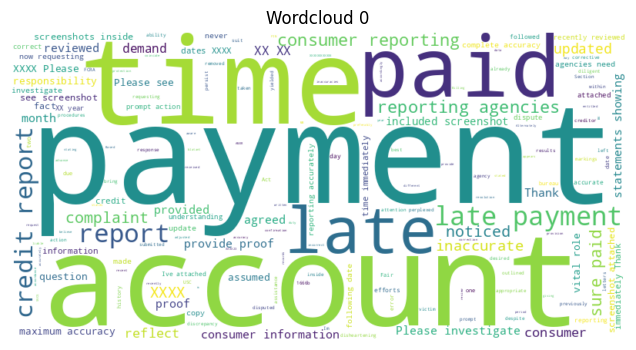
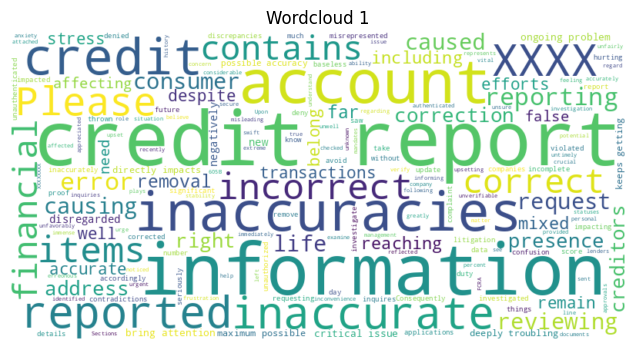
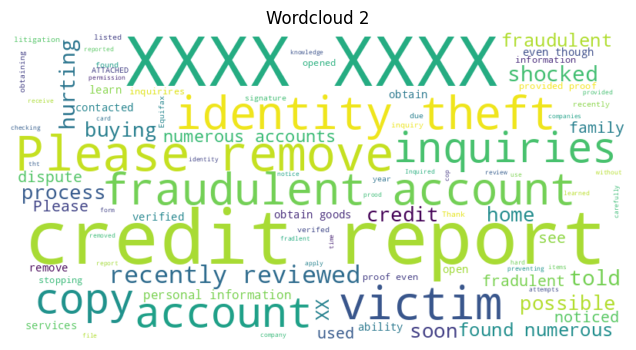
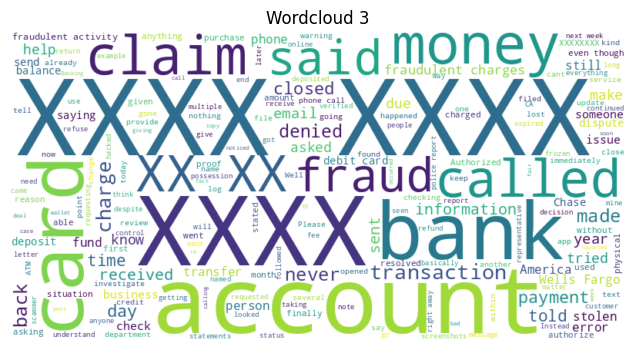
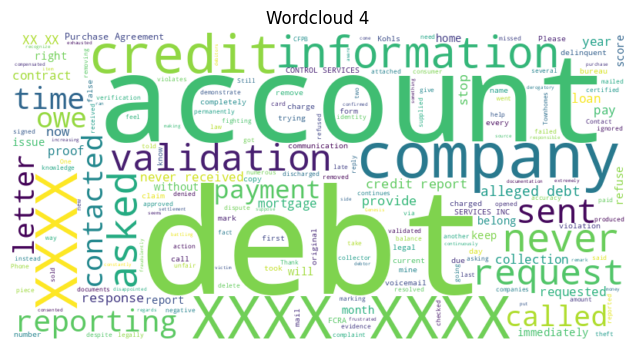
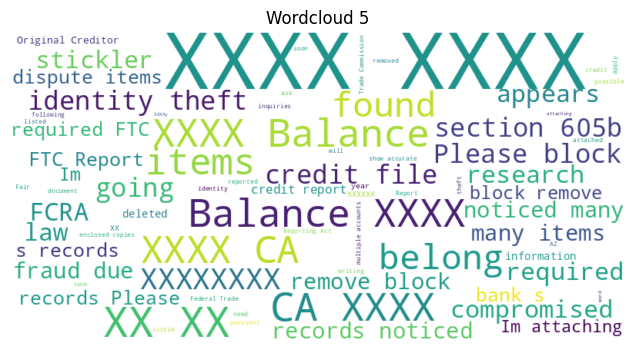
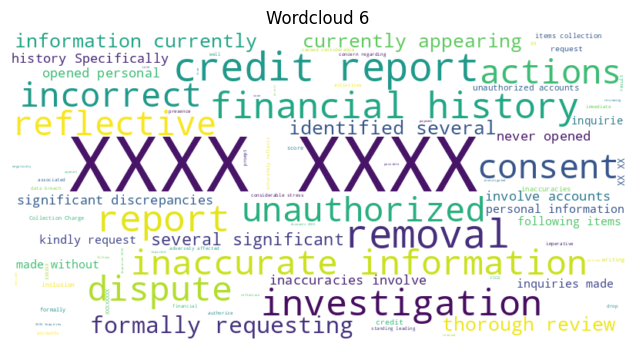
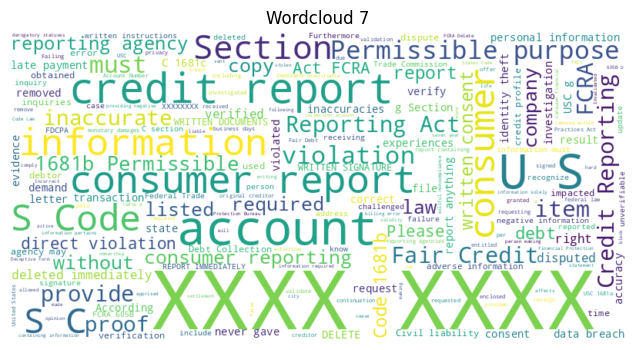
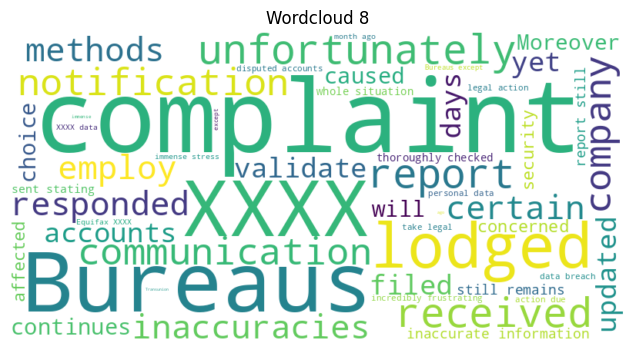
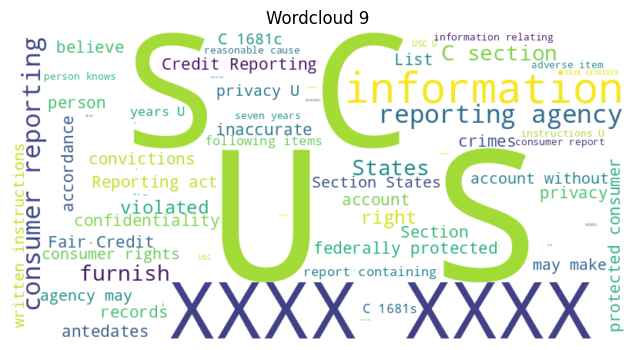

In [32]:
#from tab_widget.py
display_wordclouds_in_tabs(wordclouds)

## Get Topic Names by asking a LLM

To leverage the summarization capabilities of large-scale language models, we use a multi-billion parameter model to generate meaningful topic names based on representative complaints from each cluster. This step requires an OpenAI API key, as the model runs through an external API. If you don't have an OpenAI API key, use the pre-generated topic names below.

Also, feel free to play around with the prompt and see how this changes the cluster names.


In [33]:
# set to True, if you have an OpenAI key
I_Have_an_OpenAI_API_Key = False

In [34]:
if I_Have_an_OpenAI_API_Key:
    import os, getpass
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OPENAI API KEY")

In [35]:
if I_Have_an_OpenAI_API_Key:
    prompt_template = """Your task is to identify a common topic of 10 messages that have shown similar vector embeddings. 
    Your answer should be exactly one sentence, maximal 10 words long, summarising the topic. You can skip unneccary filler words.
    The answer should not be starting with "The common topic of the messages is", or "the topic is", or "Customers are complaining" etc.
    
    Here are the 10 messages:
    
    {messages}
    
    ====
    Topic:
    """

In [36]:
if I_Have_an_OpenAI_API_Key:
    from openai import OpenAI
    results =  {}
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    
    for i in range (10):
        cluster_feedback = '\n\n'.join(df_topmessages[df_topmessages['td_clusterid_kmeans'] == i]['consumer_complaint_narrative'])
        this_prompt = prompt_template.format(messages = cluster_feedback)
        try:
            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": this_prompt,
                    }
                ],
                model="gpt-4o",
                temperature=0,
                max_tokens=4096
            )
            results[i] = chat_completion.choices[0].message.content.strip()
        except Exception as e:
            raise ValueError(f"Failed to call OpenAI API: {str(e)}")
    

In [37]:
if not I_Have_an_OpenAI_API_Key :
    #pre-defined topics
    results = {
                 0: 'Inaccurate late payment reporting on credit reports needing correction.',
                 1: 'Inaccurate credit report information causing financial and emotional distress.',
                 2: 'Identity theft leading to fraudulent credit report entries.',
                 3: 'Bank customers experiencing issues with fraudulent charges and denied claims.',
                 4: 'Disputes over unverified debts affecting credit reports and rights.',
                 5: 'Identity theft and credit report fraud dispute resolution.',
                 6: 'Disputing unauthorized and inaccurate information on credit reports.',
                 7: 'Disputes over inaccuracies and unauthorized entries in credit reports.',
                 8: 'Inaccurate credit report information and unresolved data breach concerns.',
                 9: 'Violation of consumer privacy rights under Fair Credit Reporting Act.'}
    

In [38]:
results

{0: 'Inaccurate late payment reporting on credit reports needing correction.',
 1: 'Inaccurate credit report information causing financial and emotional distress.',
 2: 'Identity theft leading to fraudulent credit report entries.',
 3: 'Bank customers experiencing issues with fraudulent charges and denied claims.',
 4: 'Disputes over unverified debts affecting credit reports and rights.',
 5: 'Identity theft and credit report fraud dispute resolution.',
 6: 'Disputing unauthorized and inaccurate information on credit reports.',
 7: 'Disputes over inaccuracies and unauthorized entries in credit reports.',
 8: 'Inaccurate credit report information and unresolved data breach concerns.',
 9: 'Violation of consumer privacy rights under Fair Credit Reporting Act.'}

# 3) Generate Embeddings for Topics and  get Similarity

Now that we have abstracted topics from the data, we need to generate embeddings for them. This step is crucial because, in the next phase, we will calculate the **pairwise similarity** between complaints and topics, effectively computing a **Cartesian product** of all complaint-topic pairs.

To achieve this, we use the function `calculate_similarity_topics(results)`, which we import from a module. Internally, this function performs the following steps:

- **Generate topic embeddings:** Using `ONNXEmbeddings`, we create numerical representations for the topic names, following the same approach used earlier for complaint embeddings.  
- **Compute similarity scores:** We apply the `TD_VectorDistance` function to calculate the **cosine distance** between each complaint and each topic. This results in a full Cartesian product of complaint-topic similarity scores.  
- **Prepare data for the dashboard:** The computed similarity scores will serve as the foundation for our reporting tool, allowing us to track trends and analyze topic distributions over time.


In [39]:
%run utils/topics_distance.py
# imports  calculate_similarity_topics()

In [40]:
try:
    tdml.db_drop_table("complaint_topics")
except:
    pass

try:
    tdml.db_drop_table("consumer_complaint_topic_similarity")
except:
    pass

In [41]:
# creates tables complaint_topics and consumer_complaint_topic_similarity
calculate_similarity_topics(results)

In [42]:
list_relevant_tables.append("complaint_topics") # embeddings for topics
list_relevant_tables.append("consumer_complaint_topic_similarity") # similarity between complaints and topics

In [43]:
display_dataframes_in_tabs(list_relevant_tables,-2)

# Build interactive Dashboard for BI reporting

![](images/topictrenddashboard.gif)

As a final step, we build a dashboard designed to serve as a **business intelligence (BI) reporting tool**, allowing us to analyze how topic prevalence changes over time. This interactive dashboard provides a structured way to explore complaint trends and refine topic detection dynamically.

Dashboard Requirements
- **Visualizing topic trends:** Display the number of complaints per topic per month using a **multi-line chart**, filtering only those complaints with a similarity score above a defined threshold (default: **0.6**).  
- **Dynamic threshold adjustment:** Allow users to modify the similarity threshold, automatically updating the visualization in real time.  
- **Ad-hoc topic exploration:** Enable users to enter custom topics and generate new trend lines, making the tool flexible for exploratory analysis.
- **Deterministic Results:** Both embedding generation and distance calculation are **deterministic**, ensuring replicable and reliable outcomes. This contrasts with using an LLM for topic evaluation via prompt engineering, which may introduce variability and inconsistency in the results.  

The dashboard logic is encapsulated in the **`topics_widget.py`** module. Feel free to check it out and experiment with the widget—adjust the threshold, explore predefined topics, or add new ones to uncover emerging trends!


In [44]:
%run utils/topics_widget.py
#to get get_complaints_app()

In [45]:
get_complaints_app()

# Conclusion  

In this blog post, we showed how a **fully data-driven approach** can help analyze large volumes of text data, automatically identifying topics and tracking their trends over time. Instead of relying on **prompt engineering** to classify messages—which can be inconsistent, expensive, and hard to scale—we used **embeddings, clustering and Vector Distance** to get a **deterministic and repeatable** solution.  

By applying **K-Means clustering** on complaint embeddings, we discovered topics without predefining them. A **large language model (LLM)** then helped generate human-readable names for these clusters, but only once—keeping costs low while still benefiting from its summarization power. From there, we converted topic names into embeddings and calculated **vector similarities**, allowing us to efficiently map messages to topics in a **scalable and automated** way.  

The final step was building an **interactive BI dashboard** that lets users explore topic trends over time, tweak similarity thresholds, and even add **ad-hoc topics**—something that wouldn’t be feasible with pure LLM-based classification due to its cost and API-based nature. Plus, by keeping the process **fully deterministic**, results remain **consistent and explainable**, avoiding the randomness that LLM-based topic detection often introduces.  

With this approach, we get the **best of both worlds**: the flexibility of unsupervised learning, the power of embeddings, and the practicality of real-time reporting—all while keeping things **scalable, cost-efficient, and environmentally friendly**.  


# Clean Up and Close Context

In [46]:
# Set to False so you can resume this notebook later without having to load all the data, again.
delete_embeddings = False

if delete_embeddings:
    %run utils/_dataremove.ipynb

tdml.remove_context()

True

# Feedback and Questions

Share your thoughts, feedback, and ideas in the comments below, and explore resources available on the Teradata Developer Portal https://developers.teradata.com/ and Teradata Developer Community https://support.teradata.com/community.

# About the Author

Martin is a Senior Data Scientist at Teradata. With his blend of psychology and computer science, our author brings an interdisciplinary perspective to the field of data science. Currently based in Munich, Germany, Martin has integrated his curiosity about human cognition with technical skills in data analysis. His journey includes work with big data sets in psychology and beyond, as well as conducting cognitive research with great apes. Connect with Martin on LinkedIn https://www.linkedin.com/in/martin-hillebrand-9bba48108/.